In [1]:
%load_ext autoreload
# %load_ext memory_profiler
%autoreload 2
%matplotlib inline
from context import planvec

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
from skimage import measure, segmentation

from planvec import img_proc
from planvec.common import PROJECT_ROOT_PATH

In [3]:
ASSETS_DIR      = os.path.join(PROJECT_ROOT_PATH, 'test', 'assets')
INPUT_IMAGE     = 'solid_lines.jpg'
OUTPUT_PDF_NAME = 'sample_output.pdf'

input_img = planvec.io.read_img(ASSETS_DIR, INPUT_IMAGE, to_bgr=True)
img = img_proc.copy_img(input_img)  # Perform processing on image copy to keep original input unaltered
img = img_proc.rectify_wrt_red_dots(img, (1200, 700))
img = img_proc.add_gaussian_blur(img, 5, 5)

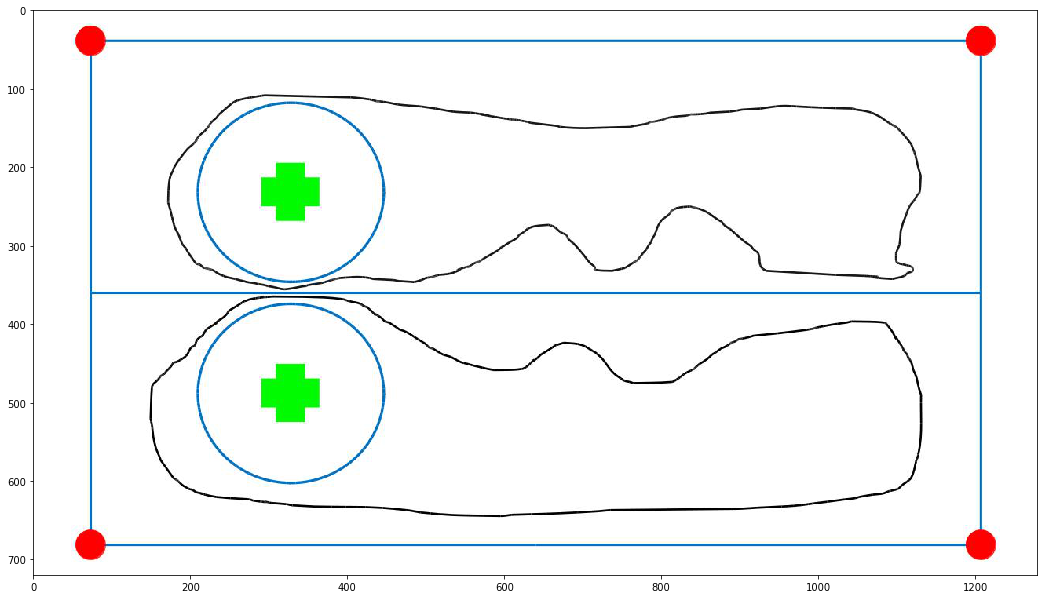

In [4]:
# Input image
planvec.vizualization.imshow(input_img, axis='on', figsize=(18,12), img_space='BGR')

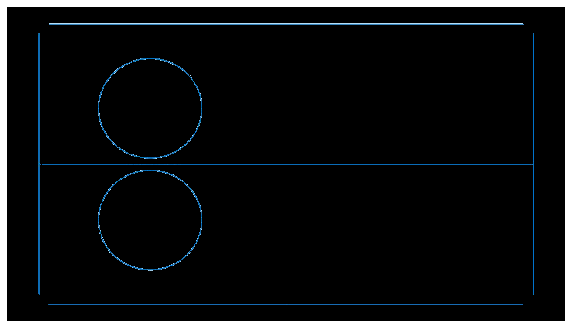

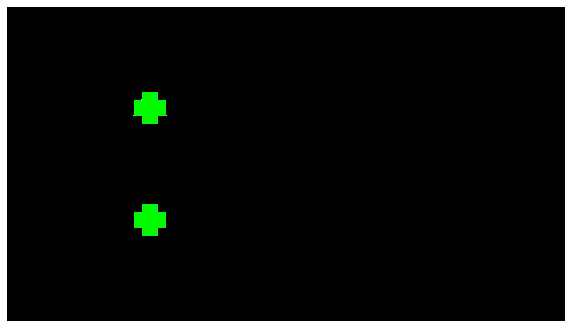

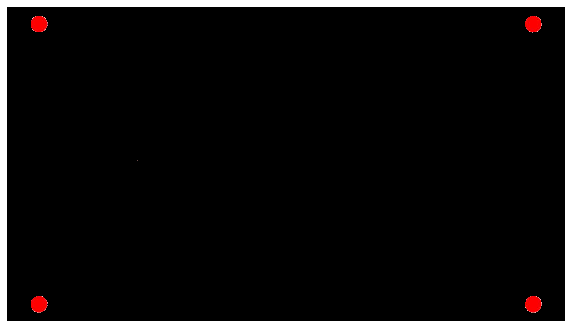

In [5]:
#planvec.vizualization.imshow(img, axis='on', figsize=(10, 10), img_space='BGR')

from planvec import color_range

img_blue = img_proc.filter_keep_by_hsv_range(input_img, color_range.BLUE)
planvec.vizualization.imshow(img_blue, axis='off', figsize=(10,10), img_space='BGR')

img_green = img_proc.filter_keep_by_hsv_range(input_img, color_range.GREEN)
planvec.vizualization.imshow(img_green, axis='off', figsize=(10,10), img_space='BGR')

img_red = img_proc.filter_keep_multi_ranges(input_img, [color_range.RED_LOW, color_range.RED_HIGH])
planvec.vizualization.imshow(img_red, axis='off', figsize=(10,10), img_space='BGR')
    
#img_clean = img_proc.filter_out_multi_ranges(input_img, [[50,59,0], [0,71,71], [170, 60, 60], [82,40,40]], [[70,255,255], [5,255,255], [180, 255, 255], [151,255,255]])
#planvec.vizualization.imshow(img_clean, axis='off', figsize=(10, 10), img_space='BGR')

In [6]:
"""
step 0 
    - filter out helper lines:
    - bounding box of the whole thing
    - circle around connection points
    - middle line
    
step 1 - filter for red edges and get 4 coordinates
    - HSV color filter

step 2 - warp image such that edge points are new edges
    - cv perspective transform
    - filter out points

step 3 - do all the processing to find contours
    - ...

step 4 - put in connector holes in correct positions
    - place it by known position ratio w.r.t. edges
"""

'\nstep 0 \n    - filter out helper lines:\n    - bounding box of the whole thing\n    - circle around connection points\n    - middle line\n    \nstep 1 - filter for red edges and get 4 coordinates\n    - HSV color filter\n\nstep 2 - warp image such that edge points are new edges\n    - cv perspective transform\n    - filter out points\n\nstep 3 - do all the processing to find contours\n    - ...\n\nstep 4 - put in connector holes in correct positions\n    - place it by known position ratio w.r.t. edges\n'

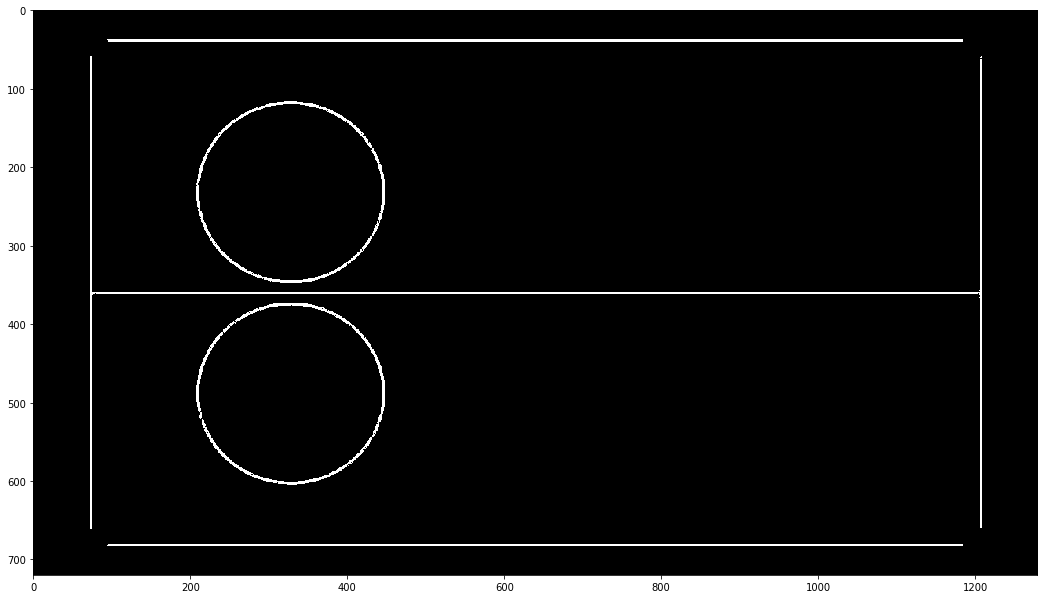

In [7]:
mask = img_proc.create_hsv_range_mask(img_proc.copy_img(input_img), color_range.BLUE)
planvec.vizualization.imshow(mask, axis='on', img_space='BGR', figsize=(18, 12))

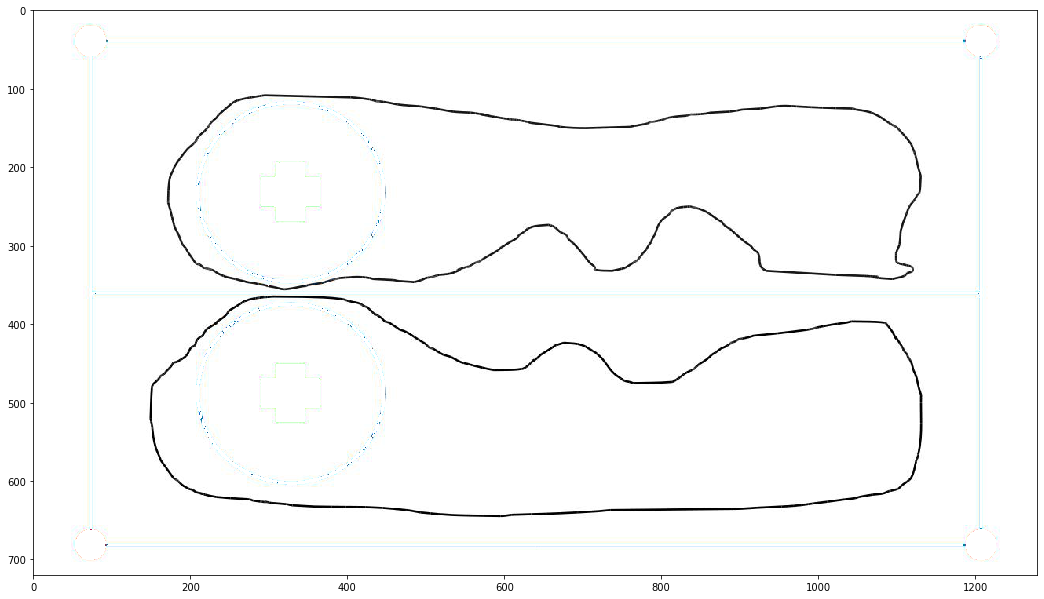

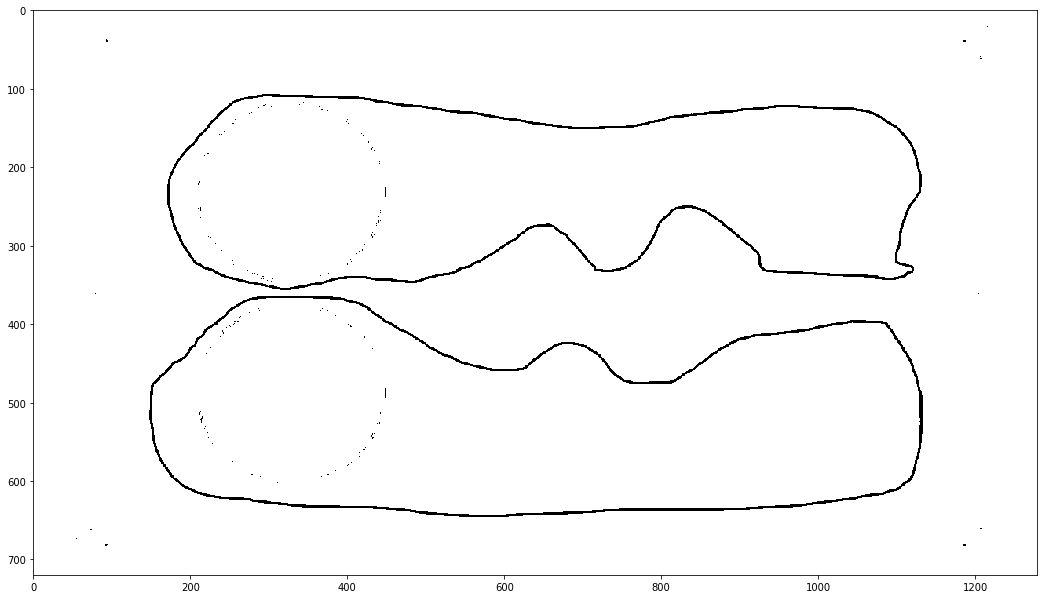

In [8]:
color_ranges = [color_range.BLUE, color_range.RED_HIGH, color_range.RED_LOW, color_range.GREEN]
img = planvec.img_proc.filter_multi_hsv_ranges_to_white(input_img, color_ranges)
planvec.vizualization.imshow(img, axis='on', img_space='BGR', figsize=(18, 12))
img = planvec.img_proc.img_to_greyscale(img)
img = img_proc.thresh_img(img, 200, 255)
planvec.vizualization.imshow(img, axis='on', img_space='BGR', figsize=(18, 12))

In [9]:
img_thresh = img_proc.thresh_img(img, thresh_val=201, max_val=255, thresh_type=cv2.THRESH_BINARY)

In [10]:
# Find and plots contours
#contours = img_proc.find_contours(img_thresh, 254)
#contours = img_proc.filter_contours_by_size(contours, n_points_thresh=1000)
#planvec.vizualization.plot_contours(contours, axis='on', figsize=(7, 10))

In [11]:
# Labelling connected regions
labelled_img, n = measure.label(img_thresh, background=0, return_num=True)
regions = measure.regionprops(labelled_img)

In [12]:
# Filtering regions
img_labelled_proc, filtered_regions = img_proc.filter_regions(labelled_img, regionprops=regions, area_threshold=50000)

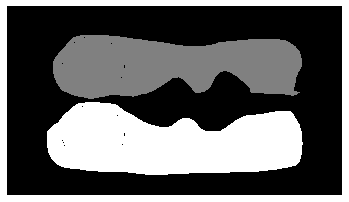

In [13]:
planvec.vizualization.imshow(img_labelled_proc)

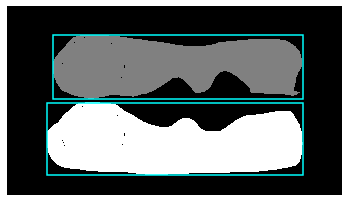

In [14]:
planvec.vizualization.plot_image_regions(img_labelled_proc, filtered_regions)

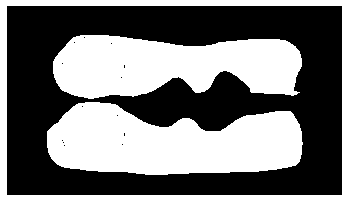

In [15]:
planvec.vizualization.imshow(img_labelled_proc!=0)

Contours left: 2


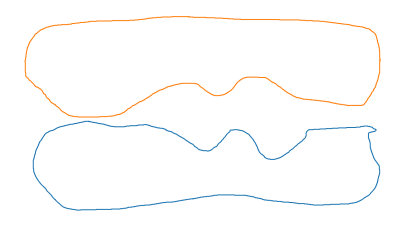

In [16]:
# Find contours of processed labelled image
contours = img_proc.find_contours(img_labelled_proc!=0, 0)
contours = img_proc.filter_contours_by_size(contours, n_points_thresh=100)
planvec.vizualization.plot_contours(contours, axis='off', figsize=(7, 10))
print(f'Contours left: {len(contours)}')

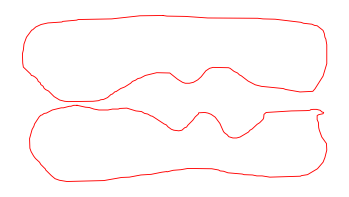

In [17]:
# Smooth contours by polygon approximation
approx_contours = []
for contour in contours:
    approx_contours.append(skimage.measure.approximate_polygon(contour.copy(), tolerance=1))
output_fig = planvec.vizualization.plot_contours(approx_contours, axis='off', color='red', linewidth=0.9)

In [18]:
output_fig.savefig('output_lw005.pdf')

In [19]:
# Stores the processed image to a PDF in the assets directory
# Deprecated
# img_proc.img_to_pdf(os.path.join(ASSETS_DIR, OUTPUT_PDF_NAME), img_thresh)

In [20]:
img_proc.live_color_filter(use_camera=False, img=img_proc.copy_img(input_img))

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)


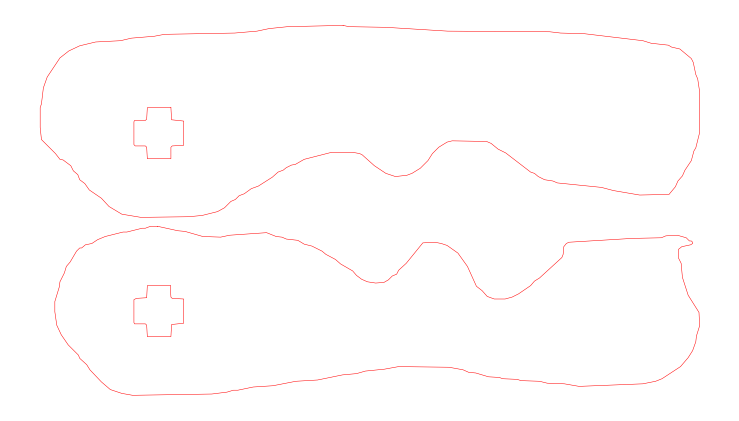

In [23]:
from planvec.pipeline import pipeline

output_img = pipeline(img_proc.copy_img(input_img), visualize_steps=False, verbose=False)

In [ ]:
output_img.savefig('output.pdf')